In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import plot_quantiles, plot_histograms, get_quantiles_from_values

---

# Loading Data

---

### Main Data File

In [2]:
data = pd.read_csv('data/sales_train.csv')
data.shape

(2935849, 6)

In [3]:
data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### Items Data

In [4]:
items = pd.read_csv('data/items.csv')
items.shape

(22170, 3)

In [5]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


### Item Categories Data

In [6]:
item_categories = pd.read_csv('data/item_categories.csv')
item_categories.shape

(84, 2)

In [7]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


### Shops Data

In [8]:
shops = pd.read_csv('data/shops.csv')
shops.shape

(60, 2)

In [9]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


<div class="alert alert-block alert-info">
- Dataset has 2.9 millions sales entries and 6 columns <br>
- There are 22k unique items referenced <br>
- There are 84 unique categories of items referenced <br>
- Products are distributed across 60 shops <br>

### Test Set

In [10]:
test = pd.read_csv('data/test.csv')
test.shape

(214200, 3)

In [11]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


---

# Data Exploration

Definitions :
- Counts : number of distinct items with at least one unit sold on a day
- Volumes : Counts * nb of units sold (item_cnt_day ) 
- Sales : Volumes * Price

---

### Missing Data

In [12]:
data.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

<div class="alert alert-block alert-info">
Dataset has no missing data

### Data Types

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


<div class="alert alert-block alert-info">
Dataset contains: <br>
- one datetime field<br>
- 3 integer ID fields<br>
- 2 float fields<br>

##### Before exploring the features, let's add a sales field

In [14]:
data['sales'] = data['item_price'] * data['item_cnt_day']

### Dates

In [15]:
data['date'] = pd.to_datetime(data['date'], format = "%d.%m.%Y")
data['date_m'] = data['date'].dt.strftime('%Y-%m')
data['date_d'] = data['date'].dt.strftime('%Y-%m-%d')

In [16]:
print(data['date'].min())
print(data['date'].max())

2013-01-01 00:00:00
2015-10-31 00:00:00


[Text(0.5, 0, '')]

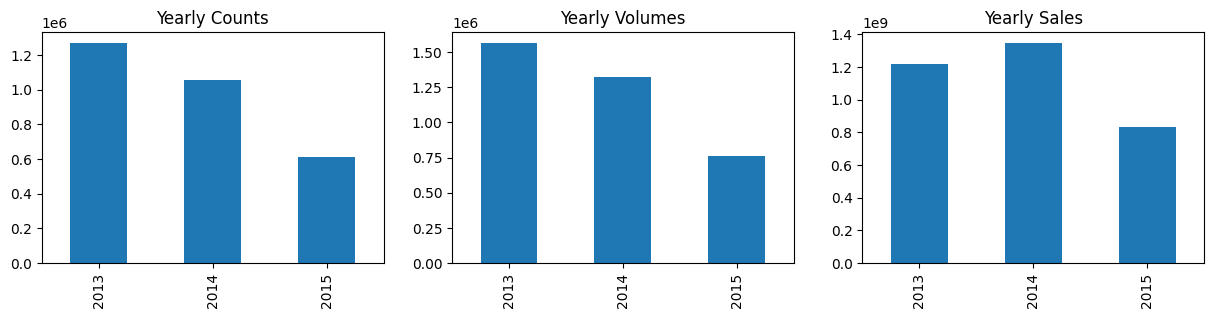

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,3))
# Yearly Counts
data['date'].dt.year.value_counts().plot.bar(ax = ax1)
ax1.set_title('Yearly Counts')
# Yearly Volumes
data.groupby(data['date'].dt.year).agg({'item_cnt_day':'sum'}).plot.bar(ax = ax2)
ax2.set_title('Yearly Volumes')
ax2.legend().set_visible(False)
ax2.set(xlabel=None)
data.groupby(data['date'].dt.year).agg({'sales':'sum'}).plot.bar(ax = ax3)
# Yearly Sales
ax3.set_title('Yearly Sales')
ax3.legend().set_visible(False)
ax3.set(xlabel=None)

<div class="alert alert-block alert-info">
- Dates range from Jan 2013 up to October 2015 <br>
- Volume trend is globally decreasing with time <br>
- Sales trend is not aligned with volume trend and has peak in 2014. <br>
- This decorrelation between Sales and Volumes could be explained either by a difference in the products sold or by a price evolution

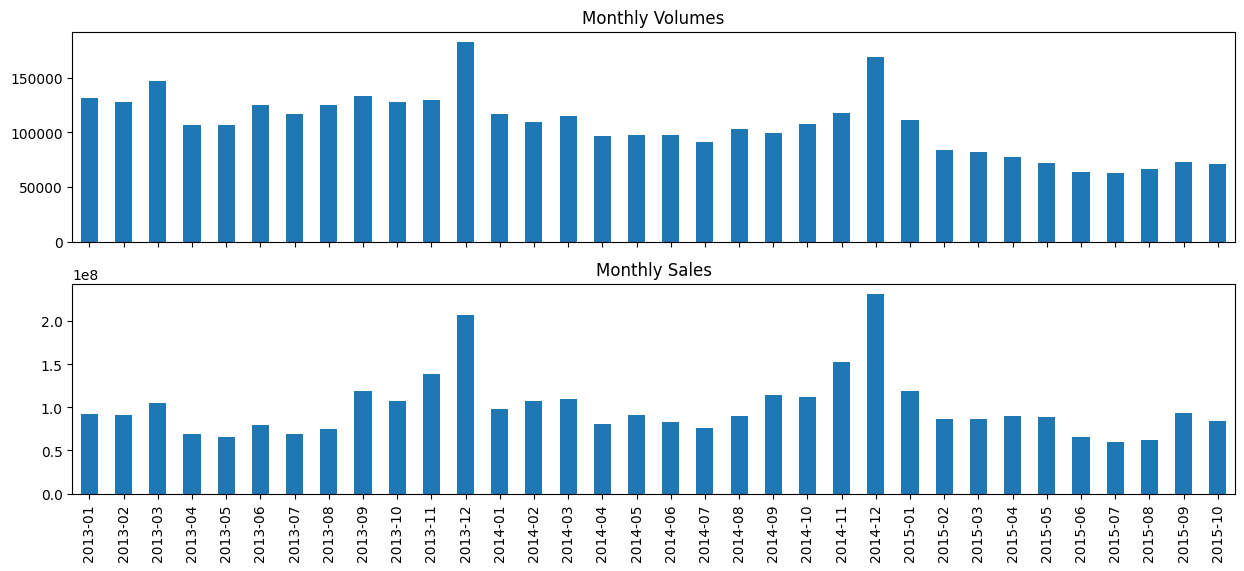

In [18]:
monthly_volumes = data.groupby(data['date_m']).agg({'item_cnt_day':'sum'})
monthly_sales = data.groupby(data['date_m']).agg({'sales':'sum'})

plot_histograms(monthly_volumes, monthly_sales, "Monthly Volumes", "Monthly Sales")

<div class="alert alert-block alert-info">
We can notice a seasonality with peak at year end <br>

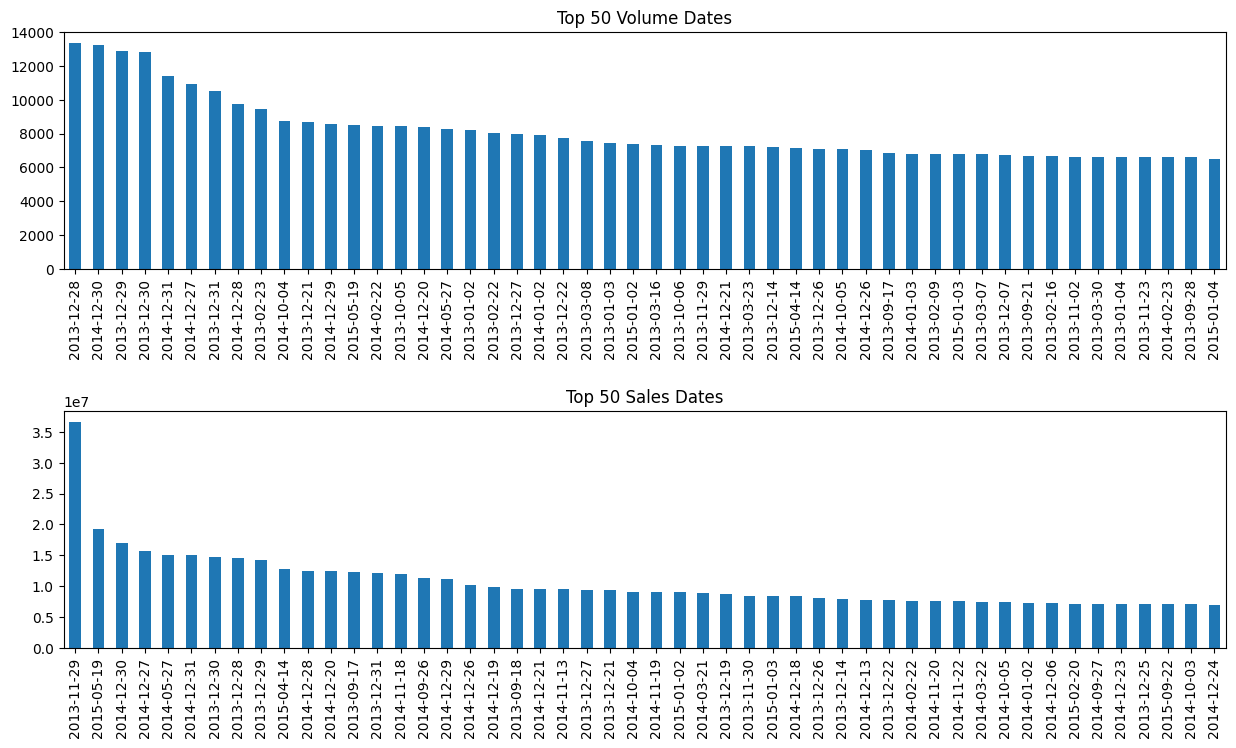

In [19]:
top_volumes = data.groupby(data['date_d']).agg({'item_cnt_day':'sum'}).sort_values(by = 'item_cnt_day', ascending = False).head(50)
top_sales = data.groupby(data['date_d']).agg({'sales':'sum'}).sort_values(by = 'sales', ascending = False).head(50)

plot_histograms(top_volumes, top_sales, "Top 50 Volume Dates", "Top 50 Sales Dates", share_axis = False, height = 8)

<div class="alert alert-block alert-info">
Peak dates are mostly last days of the year<br>
29-11-2013 was an extreme high in sales

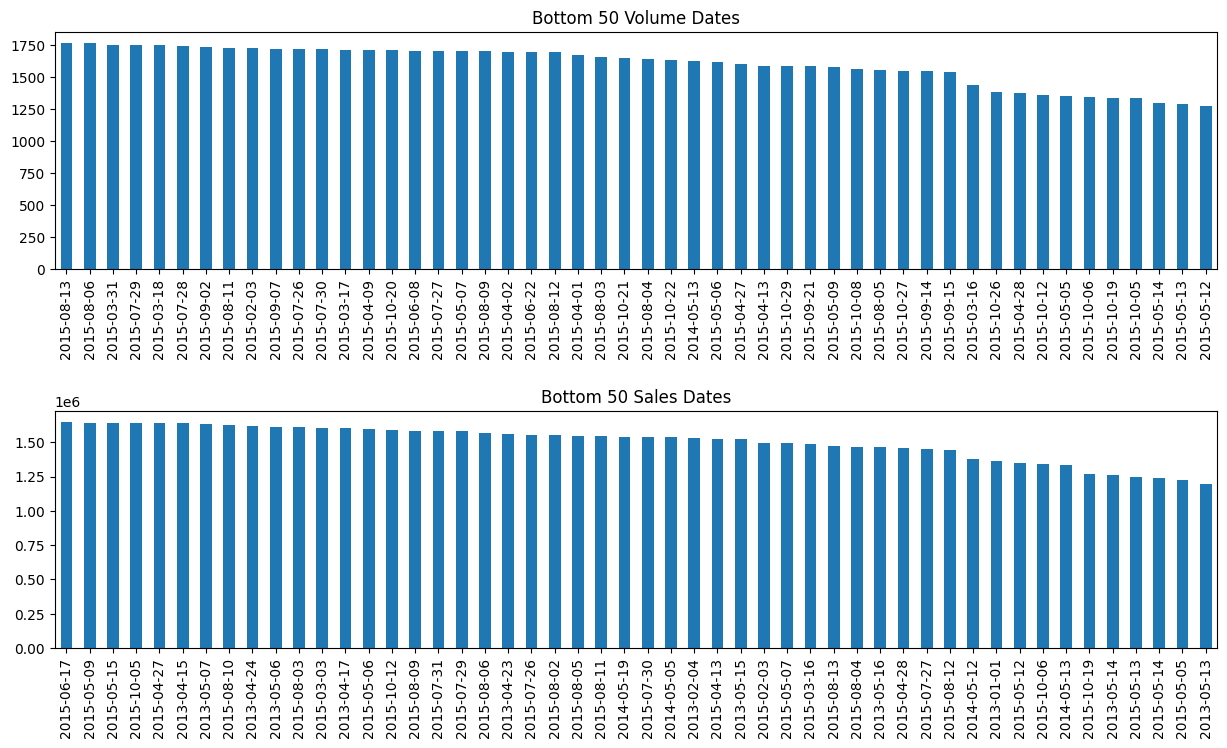

In [20]:
bottom_volumes = data.groupby(data['date_d']).agg({'item_cnt_day':'sum'}).sort_values(by = 'item_cnt_day', ascending = False).tail(50)
bottom_sales = data.groupby(data['date_d']).agg({'sales':'sum'}).sort_values(by = 'sales', ascending = False).tail(50)

plot_histograms(bottom_volumes, bottom_sales, "Bottom 50 Volume Dates", "Bottom 50 Sales Dates", share_axis = False, height = 8)

### Shops

In [21]:
data['shop_id'].nunique()

60

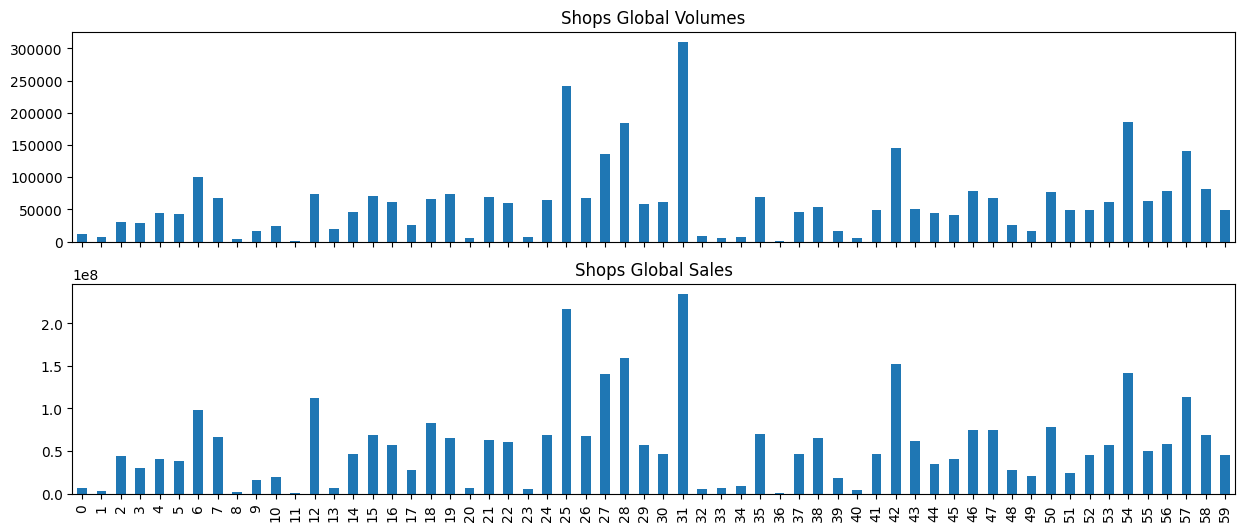

In [22]:
shop_volumes = data.groupby('shop_id').agg({'item_cnt_day':'sum'})
shop_sales = data.groupby('shop_id').agg({'sales':'sum'})

plot_histograms(shop_volumes, shop_sales, "Shops Global Volumes", "Shops Global Sales")

<div class="alert alert-block alert-info">
All 60 referenced shops are present in sales data <br>
There are strong discrepancies of volumes and sales between shops <br>

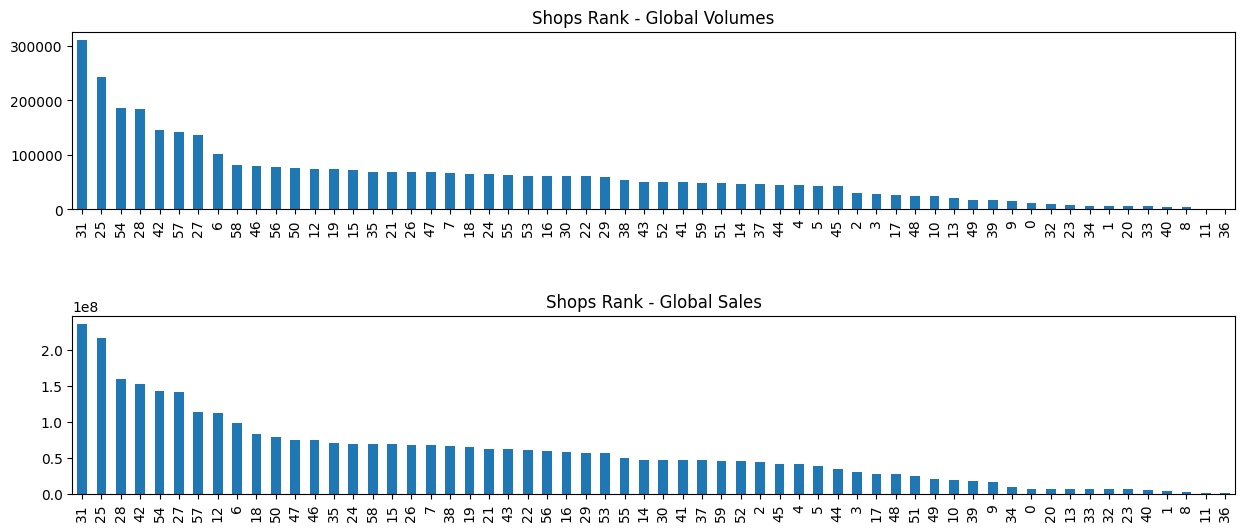

In [23]:
shop_rank_volumes = data.groupby('shop_id').agg({'item_cnt_day':'sum'}).sort_values(by ='item_cnt_day', ascending=False)
shop_rank_sales = data.groupby('shop_id').agg({'sales':'sum'}).sort_values(by ='sales', ascending=False)

plot_histograms(shop_rank_volumes, shop_rank_sales, "Shops Rank - Global Volumes", "Shops Rank - Global Sales", share_axis = False)

<div class="alert alert-block alert-info">
We can notice some difference in the ranks in volume and sales <br>
It could be explained either by <br>
    - a difference in the products sold<br>
    - a difference in the pricing <br>
    - both

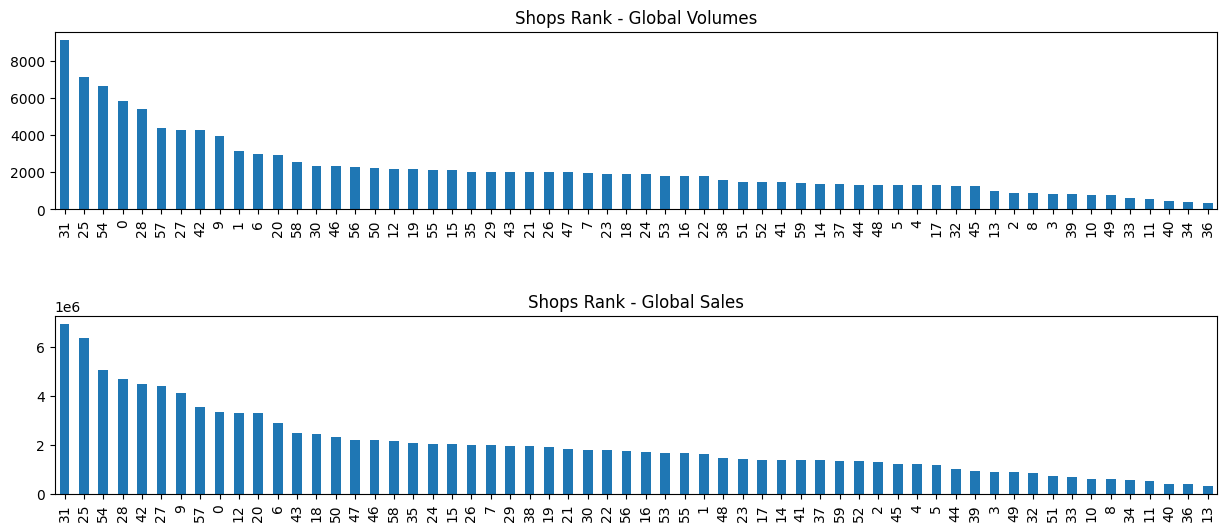

In [24]:
monthly_shop = data.groupby(['shop_id','date_block_num']).agg({'item_cnt_day':'sum','sales':'sum'})

shop_rank_monthly_volumes = monthly_shop.groupby('shop_id').agg({'item_cnt_day':'mean'}).sort_values(by ='item_cnt_day', ascending=False)
shop_rank_monthly_sales = monthly_shop.groupby('shop_id').agg({'sales':'mean'}).sort_values(by ='sales', ascending=False)

plot_histograms(shop_rank_monthly_volumes, shop_rank_monthly_sales, "Shops Rank - Global Volumes", "Shops Rank - Global Sales", share_axis = False)

<div class="alert alert-block alert-info">
Looking at the average monthly figures we can observe a few shops going up in the rank (shops 0,1,9 for instance) <br>
This is probably due to a difference in the number of months with sales between shops <br>

Text(0.5, 1.0, 'Nb of sales months per Shop')

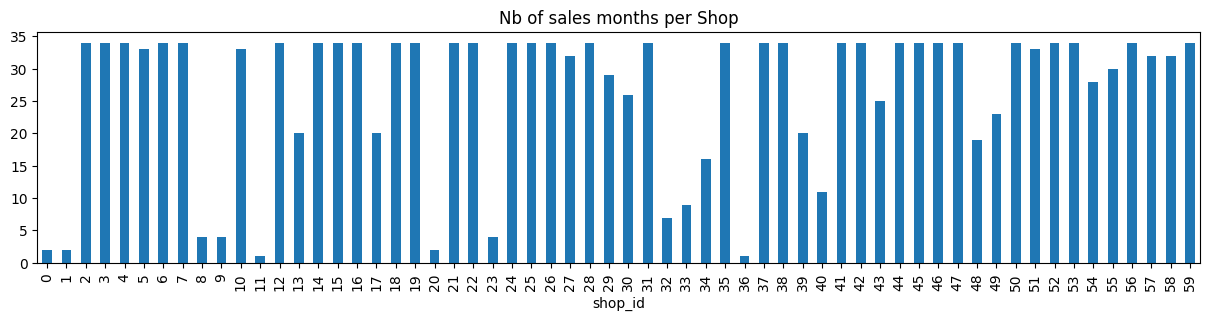

In [25]:
f, ax = plt.subplots(figsize=(15,3))

# Shop Volumes
data.groupby(['shop_id']).agg({"date_block_num" : "nunique"}).plot.bar(ax=ax)
ax.legend().set_visible(False)
ax.set_title('Nb of sales months per Shop')

In [26]:
# Shop Volumes
data.groupby(['shop_id']).agg({"date_block_num" : "nunique"})['date_block_num'].value_counts().sort_index(ascending = False)

34    32
33     3
32     3
30     1
29     1
28     1
26     1
25     1
23     1
20     3
19     1
16     1
11     1
9      1
7      1
4      3
2      3
1      2
Name: date_block_num, dtype: int64

<div class="alert alert-block alert-info">
Only half of the shops have sales records in all 34 months of observations <br>
10 shops have less than 10 months of data <br>
5 shops have less than 2 months of data <br>

### Items 

In [27]:
print(data['item_id'].nunique())
print(items['item_id'].nunique())
print(test['item_id'].nunique())

21807
22170
5100


In [28]:
all_items = set(items['item_id'].to_list())
data_items = set(data['item_id'].to_list())
missing = [item for item in all_items if item not in data_items]
len(missing)

363

In [29]:
test_items = set(test['item_id'].to_list())
print(len([a for a in test_items if a in missing]))
print(len(missing) / items.shape[0])

363
0.016373477672530445


<div class="alert alert-block alert-info">
The test set contains 363 items that are not present in training set <br>
This represents 1.6% of all referenced items <br>
We'll need a solution for that

In [57]:
item_stats = data.groupby('item_id').agg({'item_cnt_day':'sum','sales':'sum','shop_id':'nunique','date_block_num':'nunique', 'item_price':'mean'}).reset_index()

count     21807
mean        167
std        1366
min         -11
25%           7
50%          33
75%         124
max      187642
Name: item_cnt_day, dtype: int32

#### Volume

In [ ]:
item_stats['item_cnt_day'].describe().astype(int)

<div class="alert alert-block alert-info">
mean volume is 167 <br>
median volume is 33 <br>
max volume is 187,642

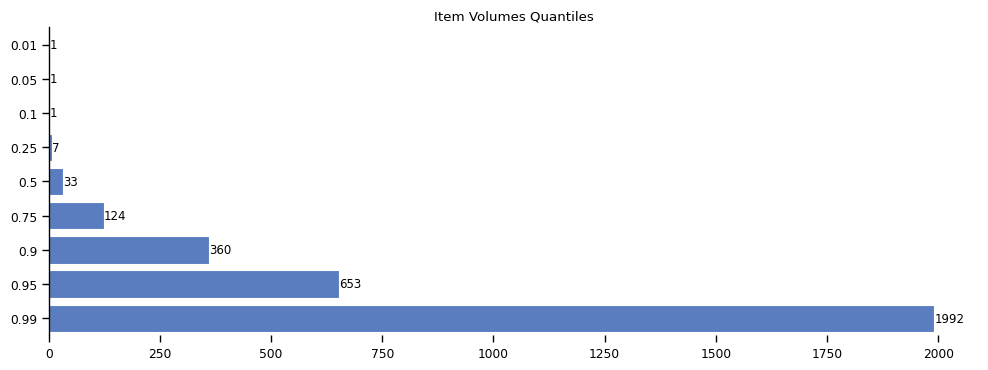

In [31]:
plot_quantiles(item_stats,'item_cnt_day', title='Item Volumes Quantiles')

In [51]:
values = [1, 10, 100, 1000, 2000]
get_quantiles_from_values(item_stats, 'item_cnt_day', values, 'volume')

5.4% of cases have volume under 1
30.1% of cases have volume under 10
71.3% of cases have volume under 100
97.2% of cases have volume under 1000
99.0% of cases have volume under 2000


In [33]:
item_stats.iloc[item_stats.item_cnt_day.idxmax()]

item_id            20949.000000
item_cnt_day      187642.000000
sales             928863.700000
shop_id               53.000000
date_block_num        31.000000
item_price             4.914856
Name: 20602, dtype: float64

<div class="alert alert-block alert-info">
Item ID 20949 is the best selling Item in volume with 187,642 units sold for a total sales amount of 928,863 dollars  <br>
It is a cheap item with an average price of 4.91$ <br>
This item has sales record in 31 of the 34 observation months and was sold in 53 shops.

In [34]:
bug_id = item_stats[item_stats['item_cnt_day']<1]['item_id'].to_list()
data[data['item_id'].isin(bug_id)].sort_values(by = 'item_id')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales,date_m,date_d
175575,2013-02-16,1,12,1590,2599.0,1.0,2599.0,2013-02,2013-02-16
55725,2013-01-10,0,8,1590,2599.0,1.0,2599.0,2013-01,2013-01-10
59155,2013-01-10,0,12,1590,2599.0,-5.0,-12995.0,2013-01,2013-01-10
59156,2013-01-18,0,12,1590,2599.0,-6.0,-15594.0,2013-01,2013-01-18
59157,2013-01-23,0,12,1590,2599.0,-1.0,-2599.0,2013-01,2013-01-23
59158,2013-01-29,0,12,1590,2599.0,-1.0,-2599.0,2013-01,2013-01-29
836635,2013-08-08,7,12,1590,2599.0,-1.0,-2599.0,2013-08,2013-08-08
302047,2013-03-07,2,12,1590,2599.0,1.0,2599.0,2013-03,2013-03-07
1051957,2013-11-05,10,31,4591,399.0,-1.0,-399.0,2013-11,2013-11-05
1051956,2013-11-02,10,31,4591,399.0,1.0,399.0,2013-11,2013-11-02


<div class="alert alert-block alert-info">
Some items have negative number of units sold  <br>
At this point it is hard to understand how to interpret these figures <br>
In several cases we have +1 and -1 which could be a way to cancel a sale <br>
We'll dig further on this when analyzing the item_cnt_day field

#### Sales

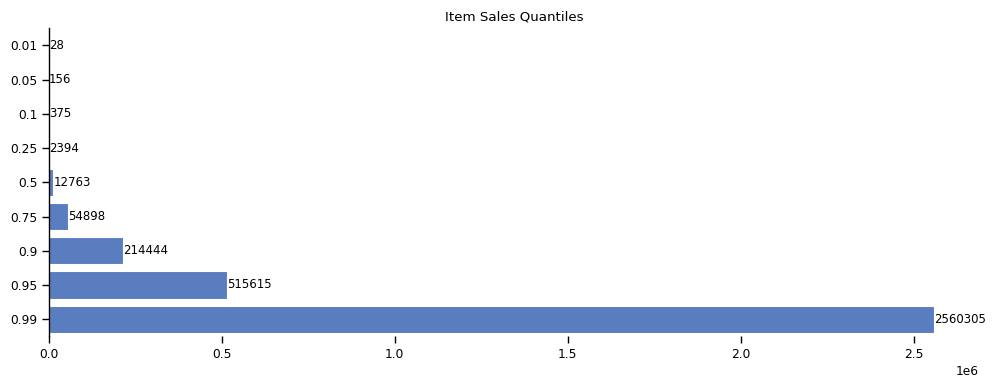

In [35]:
plot_quantiles(item_stats, 'sales', title='Item Sales Quantiles')

In [36]:
values = [100, 1000, 10000, 100000, 1000000]
get_quantiles_from_values(item_stats, 'sales', values, 'sales')

3.5% of cases have sales under 100
17.1% of cases have sales under 1000
45.5% of cases have sales under 10000
82.9% of cases have sales under 100000
97.2% of cases have sales under 1000000


In [37]:
item_stats[item_stats['sales']>100000000]

,item_id,item_cnt_day,sales,shop_id,date_block_num,item_price
6543,6675,10289.0,2.193915e+08,52,24,22113.287574


<div class="alert alert-block alert-info">
Item ID 6675 is the best selling Item in sales with 10,289 units sold for a total sales amount of 219M dollars  <br>
It is an expensive item with an average price of 22,113$ <br>
This item has sales record in 24 of the 34 observation months and was sold in 532 shops.

### Items Price

In [54]:
print(data['item_price'].nunique())
print(data['item_id'].nunique())

19992
21807


##### Before doing price statistics we will keep only one occurence of the same product price

In [40]:
price = data.drop_duplicates(['item_id','item_price'])
price.shape

(120216, 9)

In [41]:
price['item_price'].describe().astype(int)

count    120216
mean       1021
std        2547
min          -1
25%         198
50%         399
75%         999
max      307980
Name: item_price, dtype: int32

<div class="alert alert-block alert-info">
mean price is 1,000 dollars <br>
median price is 399 dollars <br>
max price is around 300,000 dollars

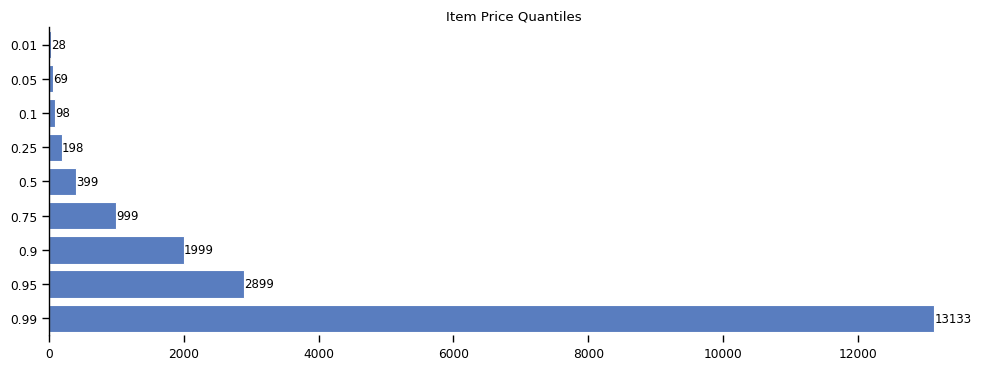

In [42]:
plot_quantiles(price, 'item_price', title='Item Price Quantiles')

In [43]:
values = [50, 100, 500, 1000, 5000]
get_quantiles_from_values(price, 'item_price', values, 'price')

2.7% of cases have price under 50
11.4% of cases have price under 100
57.0% of cases have price under 500
75.6% of cases have price under 1000
97.6% of cases have price under 5000


In [44]:
price[price['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales,date_m,date_d
484683,2013-05-15,4,32,2973,-1.0,1.0,-1.0,2013-05,2013-05-15


In [45]:
data[(data['item_id']==2973) & (data['shop_id']==32)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales,date_m,date_d
67427,2013-01-29,0,32,2973,2499.0,1.0,2499.0,2013-01,2013-01-29
67428,2013-01-25,0,32,2973,2499.0,1.0,2499.0,2013-01,2013-01-25
67429,2013-01-22,0,32,2973,2499.0,1.0,2499.0,2013-01,2013-01-22
67430,2013-01-21,0,32,2973,2499.0,1.0,2499.0,2013-01,2013-01-21
67431,2013-01-18,0,32,2973,2499.0,1.0,2499.0,2013-01,2013-01-18
67432,2013-01-17,0,32,2973,2499.0,1.0,2499.0,2013-01,2013-01-17
67433,2013-01-15,0,32,2973,2499.0,3.0,7497.0,2013-01,2013-01-15
187844,2013-02-05,1,32,2973,2499.0,1.0,2499.0,2013-02,2013-02-05
187845,2013-02-14,1,32,2973,2499.0,1.0,2499.0,2013-02,2013-02-14
484682,2013-05-23,4,32,2973,1249.0,1.0,1249.0,2013-05,2013-05-23


<div class="alert alert-block alert-info">
1 item has negative price but we can correct this price by looking at the other sales for the same product in the same shop <br>
It is a bit tricky as the prior sale price was 2499 and the next sale price after was 1249 (looks like a 50% discount) <br>
We will use the original price which is the most frequent: 2499 <br>

In [46]:
data.loc[data['item_price']==-1,'item_price'] = 2499

In [58]:
# number of different price per item
price.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales,date_m,date_d
0,2013-01-02,0,59,22154,999.00,1.0,999.00,2013-01,2013-01-02
1,2013-01-03,0,25,2552,899.00,1.0,899.00,2013-01,2013-01-03
3,2013-01-06,0,25,2554,1709.05,1.0,1709.05,2013-01,2013-01-06
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00,2013-01,2013-01-15
5,2013-01-10,0,25,2564,349.00,1.0,349.00,2013-01,2013-01-10


In [86]:
item_price = price.groupby('item_id').agg({'item_price':'nunique'}).value_counts().sort_index().reset_index()
item_price.columns = ['item_id','nb_of_prices']

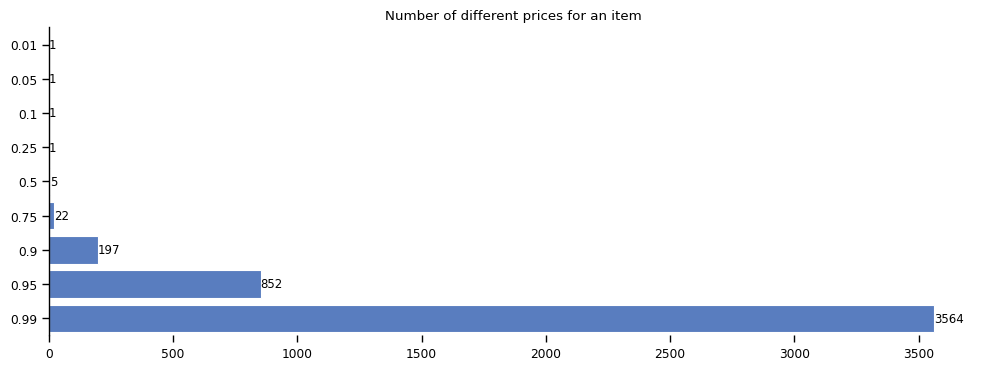

In [87]:
plot_quantiles(item_price, 'nb_of_prices', title='Number of different prices for an item')

In [103]:
values = [1,2, 5, 10, 20 ,50 ,100, 1000]
get_quantiles_from_values(item_price, 'nb_of_prices', values, 'nb of Prices')

15.8% of cases have nb of Prices under 1
35.9% of cases have nb of Prices under 2
51.3% of cases have nb of Prices under 5
60.3% of cases have nb of Prices under 10
70.9% of cases have nb of Prices under 20
81.2% of cases have nb of Prices under 50
85.5% of cases have nb of Prices under 100
94.9% of cases have nb of Prices under 1000


<div class="alert alert-block alert-info">
half of the items have less than 5 different prices <br>
15% of the items have more than 100 different prices <br>
Price variation could be influenced by the following factors:<br>
- Date of the sale (with underlying economical context)<br>
- Shop of the sale <br>
- Potential discounts applied <br><br>

Let's dig further into this

In [98]:
item_shop_price = price.groupby(['item_id','shop_id']).agg({'item_price':'nunique'}).value_counts().sort_index().reset_index()
item_shop_price.columns = ['shop-item','nb_of_prices']

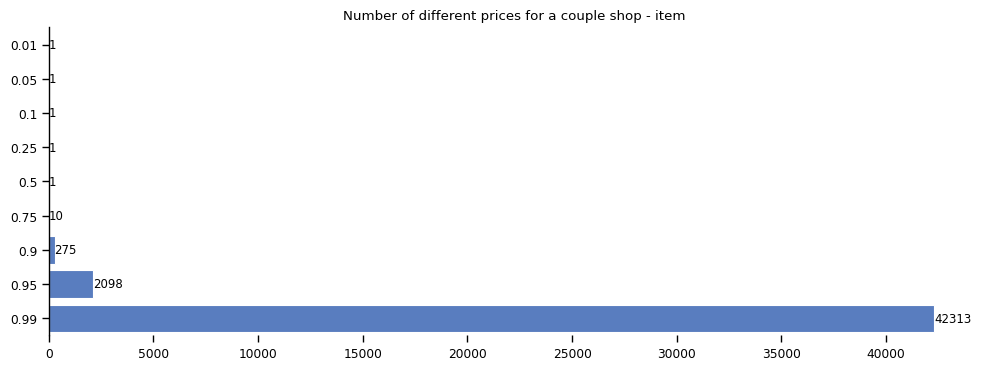

In [99]:
plot_quantiles(item_shop_price, 'nb_of_prices', title='Number of different prices for a couple shop - item')

In [102]:
values = [1,2, 5, 10, 20 ,50 ,100, 1000]
get_quantiles_from_values(item_shop_price, 'nb_of_prices', values, 'nb of Prices')

27.5% of cases have nb of Prices under 1
61.8% of cases have nb of Prices under 2
72.5% of cases have nb of Prices under 5
74.5% of cases have nb of Prices under 10
80.4% of cases have nb of Prices under 20
84.3% of cases have nb of Prices under 50
86.3% of cases have nb of Prices under 100
92.2% of cases have nb of Prices under 1000


<div class="alert alert-block alert-info">
73% of the items have less than 5 different prices <br>
15% of the items have more than 100 different prices <br>
Price variation 
Let's look at the price variation for a couple item - shop